In [1]:
import numpy as np
import pickle
from scipy.io import savemat, loadmat
from sklearn.metrics import normalized_mutual_info_score, adjusted_rand_score, f1_score, accuracy_score
from matplotlib.colors import Normalize
import sys
sys.path.insert(0, "/Users/bengieru/MLN/Results/general_diagnostics_00/")

from helpers import *
import matplotlib.pyplot as plt
import pickle
from math import floor
import random
import matplotlib as mpl

In [2]:
def generate_ground_truth(comm_sizes, method = 'scattered', pad = False, community_operation = 'grow'):
    ##genertaes community labels according to two methods one in which the rest of the network except the planted communities
    # are scattered i.e. they all have their own community or they are all in one community, integrated.
    if community_operation == 'grow':
        layers = len(comm_sizes)
        if method == 'scattered':
            truth_labels = [0 for i in range(sum(comm_sizes[:1]))] + list(np.arange(1, sum(comm_sizes[1:])+1))
            
            truth_labels_tip = truth_labels
                     
            for j in range(2,layers):
                truth_labels = truth_labels + [0 for i in range(sum(comm_sizes[:j]))] + truth_labels_tip[sum(comm_sizes[:j]):]
            
            truth_labels = truth_labels + [0 for i in range(sum(comm_sizes[:layers]))]
            
            if pad:
                truth_labels = truth_labels_tip + truth_labels
                truth_labels = truth_labels + [0 for i in range(sum(comm_sizes[:layers]))]  
        
        if method == 'integrated':
        
            truth_labels = [0 for i in range(sum(comm_sizes[:1]))] + [1 for i in range(sum(comm_sizes[1:]))]
            if pad: truth_labels = truth_labels + truth_labels
            for j in range(2,layers):
                truth_labels = truth_labels + [0 for i in range(sum(comm_sizes[:j]))] + [1 for i in range(sum(comm_sizes[j:]))]

            if pad:
                truth_labels = truth_labels + [0 for i in range(sum(comm_sizes[:layers]))]
                truth_labels = truth_labels + [0 for i in range(sum(comm_sizes[:layers]))]
    
    elif community_operation == 'contract':
        layers = len(comm_sizes)
        if method == 'scattered':
            truth_labels_tip = [0 for i in range(sum(comm_sizes))]
            truth_labels_end = [0 for i in range(sum(comm_sizes[:1]))] + list(np.arange(1, sum(comm_sizes[1:])+1))
            truth_labels = truth_labels_tip
            
            for j in range(1,layers):
                truth_labels = truth_labels + [0 for i in range(sum(comm_sizes[:(layers-j)]))] + truth_labels_end[sum(comm_sizes[:(layers-j)]):]
            
            
            if pad:
                truth_labels = truth_labels_tip + truth_labels + truth_labels_end
                
        if method == 'integrated':
            truth_labels = [0 for i in range(sum(comm_sizes))]
            truth_labels_tip = truth_labels
            for j in range(1,layers):
                truth_labels = truth_labels + [0 for i in range(sum(comm_sizes[:(layers-j)]))] + [1 for i in range(sum(comm_sizes[(layers-j):]))]
                
            truth_labels_end = truth_labels[sum(comm_sizes)*(layers-1):]
            if pad:
                truth_labels = truth_labels_tip + truth_labels +truth_labels_end
            
                
    elif community_operation == 'merge': ##only for two layers
        truth_labels = []
        
        for j,f in enumerate(comm_sizes[0]):
            truth_labels = truth_labels + [j for k in range(f)]
    
        for j,f in enumerate([6,3,7]):##communities that are merged in the first layer are assigned one of the labels of 
            #merged communities 
            truth_labels = truth_labels + [f for i in range(comm_sizes[1][j])]
            
        if pad:
            l1 = truth_labels[:sum(comm_sizes[0])]
            l2 = truth_labels[sum(comm_sizes[0]):]
            truth_labels = l1 + truth_labels +l2
            
    return(truth_labels)

# load dppm

In [3]:
thresholds_dppm = np.linspace(0.05,0.55,11)
layers = 7
path = '/Users/bengieru/MLN/Results/general_diagnostics_00/C_ESCR/'
with open(path + 'comm_size.pkl', 'rb') as handle:
    C_ESCR_comm_size_dppm = pickle.load(handle) 
    
num_neurons = sum(C_ESCR_comm_size_dppm)

path = '/Users/bengieru/MLN/Results/general_diagnostics_00/C_ESCR/DPPM/'

In [4]:
communities = loadmat(path + 'communitites_C_ESCR.mat')
vertices = loadmat(path + 'vertices_C_ESCR.mat')

In [5]:
for i,e in enumerate(thresholds_dppm):
    for j in range(9):
        overlapping_partition2 = int(vertices['v_C_ESCR'][0][0][i][0][0][0][j].shape[0]-1)#random.randint(0,vertices['v_G_FSCR'][0][0][i][0][0][0][j].shape[0]-1)
        overlapping_partition3 = int(vertices['v_C_ESCR'][0][0][i][0][1][0][j].shape[0]-1)
        if overlapping_partition2 <0 or overlapping_partition3<0:
            try:
                vertices['v_C_ESCR'][0][0][i][0][0][0][j] = vertices['v_C_ESCR'][0][0][i][0][0][0][j-1]
                vertices['v_C_ESCR'][0][0][i][0][1][0][j] = vertices['v_C_ESCR'][0][0][i][0][1][0][j-1]
            except:
                vertices['v_C_ESCR'][0][0][i][0][0][0][j] = vertices['v_C_ESCR'][0][0][i][0][0][0][j+1]
                vertices['v_C_ESCR'][0][0][i][0][1][0][j] = vertices['v_C_ESCR'][0][0][i][0][1][0][j+1]

In [6]:
labels0_k_2 = {}
labels0_k_3 = {}
for i,e in enumerate(thresholds_dppm):
    li2 = []
    li3 = []
    for j in range(9):
        overlapping_partition2 = random.randint(0,vertices['v_C_ESCR'][0][0][i][0][0][0][j].shape[0]-1)
        overlapping_partition3 = random.randint(0,vertices['v_C_ESCR'][0][0][i][0][1][0][j].shape[0]-1)
        li2 = li2 + list(vertices['v_C_ESCR'][0][0][i][0][0][0][j][overlapping_partition2])
        li3 = li3 + list(vertices['v_C_ESCR'][0][0][i][0][1][0][j][overlapping_partition3])
    labels0_k_2['%d'%i] = li2
    labels0_k_3['%d'%i] = li3
    
labels1_k_2 = {}
labels1_k_3 = {}
for i,e in enumerate(thresholds_dppm):
    li2 = []
    li3 = []
    for j in range(9):
        overlapping_partition2 = random.randint(0,vertices['v_C_ESCR'][0][0][i][0][0][0][j].shape[0]-1)
        overlapping_partition3 = random.randint(0,vertices['v_C_ESCR'][0][0][i][0][1][0][j].shape[0]-1)
        li2 = li2 + list(vertices['v_C_ESCR'][0][0][i][0][0][0][j][overlapping_partition2])
        li3 = li3 + list(vertices['v_C_ESCR'][0][0][i][0][1][0][j][overlapping_partition3])
    labels1_k_2['%d'%i] = li2
    labels1_k_3['%d'%i] = li3
    
labels2_k_2 = {}
labels2_k_3 = {}
for i,e in enumerate(thresholds_dppm):
    li2 = []
    li3 = []
    for j in range(9):
        overlapping_partition2 = random.randint(0,vertices['v_C_ESCR'][0][0][i][0][0][0][j].shape[0]-1)
        overlapping_partition3 = random.randint(0,vertices['v_C_ESCR'][0][0][i][0][1][0][j].shape[0]-1)
        li2 = li2 + list(vertices['v_C_ESCR'][0][0][i][0][0][0][j][overlapping_partition2])
        li3 = li3 + list(vertices['v_C_ESCR'][0][0][i][0][1][0][j][overlapping_partition3])
    labels2_k_2['%d'%i] = li2
    labels2_k_3['%d'%i] = li3
    
labels3_k_2 = {}
labels3_k_3 = {}
for i,e in enumerate(thresholds_dppm):
    li2 = []
    li3 = []
    for j in range(9):
        overlapping_partition2 = random.randint(0,vertices['v_C_ESCR'][0][0][i][0][0][0][j].shape[0]-1)
        overlapping_partition3 = random.randint(0,vertices['v_C_ESCR'][0][0][i][0][1][0][j].shape[0]-1)
        li2 = li2 + list(vertices['v_C_ESCR'][0][0][i][0][0][0][j][overlapping_partition2])
        li3 = li3 + list(vertices['v_C_ESCR'][0][0][i][0][1][0][j][overlapping_partition3])
    labels3_k_2['%d'%i] = li2
    labels3_k_3['%d'%i] = li3

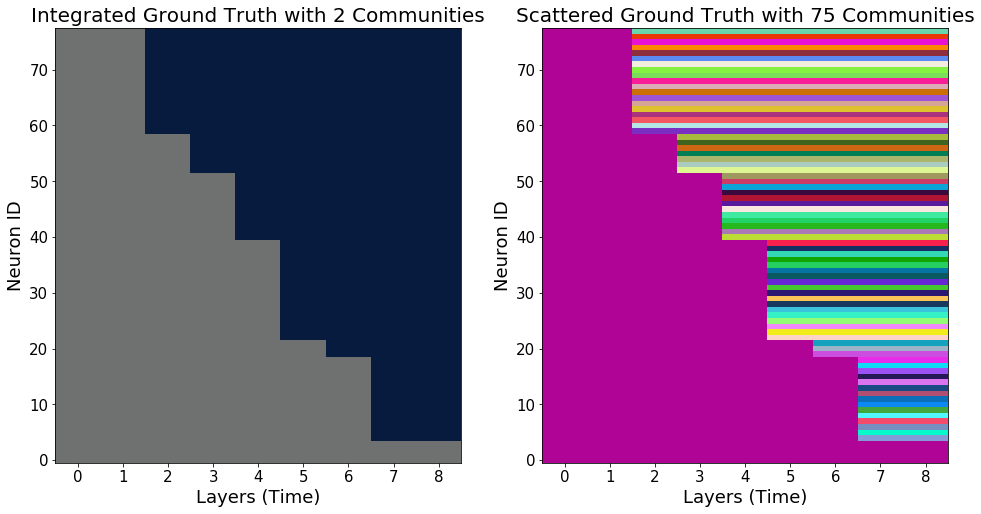

In [7]:
display_truth(C_ESCR_comm_size_dppm, 'contract')

# load mmm

In [8]:
path = '/Users/bengieru/MLN/Results/general_diagnostics_00/C_ESCR/'

with open(path + 'comm_size.pkl', 'rb') as handle:
    C_ESCR_comm_size_mmm = pickle.load(handle)
with open(path + 'spikes.pkl', 'rb') as handle:
    C_ESCR_spikes_mmm = pickle.load(handle)

grid = 51
interlayers = np.linspace(0, 1.50, grid)
resolutions = np.linspace(0, 1.50, grid)

path = path + 'MMM/'

with open(path + 'MMM_labels_no_update.pkl', 'rb') as handle:
    C_ESCR_labels0_mmm = pickle.load(handle)

## Load Infomap

In [9]:
path = '/Users/bengieru/MLN/Results/general_diagnostics_00/C_ESCR/'

with open(path + 'comm_size.pkl', 'rb') as handle:
    C_ESCR_comm_size_infomap = pickle.load(handle)
with open(path + 'spikes.pkl', 'rb') as handle:
    C_ESCR_spikes_infomap = pickle.load(handle)

grid = 51
thresholds_infomap = np.linspace(0, 0.8, grid)
interlayers = np.linspace(0, 1.5, grid)

path = path + 'Infomap/'

with open(path + 'infomap_labels_no_update.pkl', 'rb') as handle:
    C_ESCR_labels0_infomap = pickle.load(handle)


## Load Tensor_Parafac

In [10]:
path = '/Users/bengieru/MLN/Results/general_diagnostics_00/C_ESCR/'

with open(path + 'comm_size.pkl', 'rb') as handle:
    C_ESCR_comm_size_tensor = pickle.load(handle)
with open(path + 'spikes.pkl', 'rb') as handle:
    C_ESCR_spikes_tensor = pickle.load(handle)

thresholds_tensor = np.linspace(0,0.4,21)
ranks_tensor = np.arange(2,50)

path = path + 'Tensor_Parafac/'

with open(path + 'labels_no_update.pkl', 'rb') as handle:
    C_ESCR_labels0_tensor = pickle.load(handle)

## Load DSBM

In [11]:
path = '/Users/bengieru/MLN/Results/general_diagnostics_00/C_ESCR/'

with open(path + 'comm_size.pkl', 'rb') as handle:
    C_ESCR_comm_size_dsbm = pickle.load(handle)
with open(path + 'spikes.pkl', 'rb') as handle:
    C_ESCR_spikes_dsbm = pickle.load(handle)

thresholds_dsbm = np.linspace(0.2,0.4,11)
solver = [1,2,3]

path = path + 'DSBM/'

with open(path + 'states_deg_corr.pkl', 'rb') as handle:
    C_ESCR_dsbm = pickle.load(handle)

In [12]:
C_ESCR_labels0_dsbm = np.zeros((len(thresholds_dsbm)*len(solver), num_neurons*(layers+2)))
for j in range(len(solver)):
    for i,e in enumerate(thresholds_dsbm):
        C_ESCR_labels0_dsbm[j,:] = C_ESCR_dsbm['%.2f'%e][j]

## Compare 5 of 'em

In [13]:
NMI1_mmm_0 = np.zeros((len(interlayers), len(resolutions)))
NMI1_infomap_0 = np.zeros((len(interlayers), len(thresholds_infomap)))
NMI1_dppm_0 = np.zeros((2, len(thresholds_dppm)))
NMI1_tensor_0 = np.zeros((len(ranks_tensor), len(thresholds_tensor)))
NMI1_dsbm_0 = np.zeros((len(solver), len(thresholds_dppm)))

ARI1_mmm_0 = np.zeros((len(interlayers), len(resolutions)))
ARI1_infomap_0 = np.zeros((len(interlayers), len(thresholds_infomap)))
ARI1_dppm_0 = np.zeros((2, len(thresholds_dppm)))
ARI1_tensor_0 = np.zeros((len(ranks_tensor), len(thresholds_tensor)))
ARI1_dsbm_0 = np.zeros((len(solver), len(thresholds_dppm)))

F1S1_mmm_0 = np.zeros((len(interlayers), len(resolutions)))
F1S1_infomap_0 = np.zeros((len(interlayers), len(thresholds_infomap)))
F1S1_dppm_0 = np.zeros((2, len(thresholds_dppm)))
F1S1_tensor_0 = np.zeros((len(ranks_tensor), len(thresholds_tensor)))
F1S1_dsbm_0 = np.zeros((len(solver), len(thresholds_dppm)))

ACC1_mmm_0 = np.zeros((len(interlayers), len(resolutions)))
ACC1_infomap_0 = np.zeros((len(interlayers), len(thresholds_infomap)))
ACC1_dppm_0 = np.zeros((2, len(thresholds_dppm)))
ACC1_tensor_0 = np.zeros((len(ranks_tensor), len(thresholds_tensor)))
ACC1_dsbm_0 = np.zeros((len(solver), len(thresholds_dppm)))

true_labels_integ_info = generate_ground_truth(C_ESCR_comm_size_infomap, method = 'scattered', pad = True, community_operation = 'contract')
true_labels_integ_mmm = generate_ground_truth(C_ESCR_comm_size_mmm, method = 'integrated', pad = True, community_operation = 'contract')
true_labels_integ_dppm = generate_ground_truth(C_ESCR_comm_size_dppm, method = 'integrated', pad = True, community_operation = 'contract')
true_labels_integ_tensor = generate_ground_truth(C_ESCR_comm_size_tensor, method = 'integrated', pad = True, community_operation = 'contract')
true_labels_integ_dsbm = generate_ground_truth(C_ESCR_comm_size_dsbm, method = 'integrated', pad = True, community_operation = 'contract')

for j in range(len(thresholds_dppm)-2):
    NMI1_dppm_0[0][j] = normalized_mutual_info_score(true_labels_integ_dppm, labels0_k_2['%d'%j], average_method = 'max')
    NMI1_dppm_0[1][j] = normalized_mutual_info_score(true_labels_integ_dppm, labels0_k_3['%d'%j], average_method = 'max')
    
    ARI1_dppm_0[0][j] = adjusted_rand_score(true_labels_integ_dppm, labels0_k_2['%d'%j])
    ARI1_dppm_0[1][j] = adjusted_rand_score(true_labels_integ_dppm, labels0_k_3['%d'%j])
    
    F1S1_dppm_0[0][j] = f1_score(true_labels_integ_dppm, labels0_k_2['%d'%j], average = 'weighted')
    F1S1_dppm_0[1][j] = f1_score(true_labels_integ_dppm, labels0_k_3['%d'%j], average = 'weighted')
    
    ACC1_dppm_0[0][j] = accuracy_score(true_labels_integ_dppm, labels0_k_2['%d'%j], normalize = True)
    ACC1_dppm_0[1][j] = accuracy_score(true_labels_integ_dppm, labels0_k_3['%d'%j], normalize = True)
    
for i in range(len(interlayers)):
    for j in range(len(resolutions)):
        NMI1_mmm_0[i][j] = normalized_mutual_info_score(true_labels_integ_mmm, list(C_ESCR_labels0_mmm[i*len(resolutions)+j].astype(int)), average_method = 'max')
        ARI1_mmm_0[i][j] = adjusted_rand_score(true_labels_integ_mmm, list(C_ESCR_labels0_mmm[i*len(resolutions)+j].astype(int)))
        F1S1_mmm_0[i][j] = f1_score(true_labels_integ_mmm, list(C_ESCR_labels0_mmm[i*len(resolutions)+j].astype(int)), average = 'weighted')
        ACC1_mmm_0[i][j] = accuracy_score(true_labels_integ_mmm, list(C_ESCR_labels0_mmm[i*len(resolutions)+j].astype(int)), normalize = True)
        
for i in range(len(interlayers)):
    for j in range(len(thresholds_infomap)):
        NMI1_infomap_0[i][j] = normalized_mutual_info_score(true_labels_integ_info, list(C_ESCR_labels0_infomap[i*len(thresholds_infomap)+j].astype(int)), average_method = 'max')
        ARI1_infomap_0[i][j] = adjusted_rand_score(true_labels_integ_info, list(C_ESCR_labels0_infomap[i*len(thresholds_infomap)+j].astype(int)))
        F1S1_infomap_0[i][j] = f1_score(true_labels_integ_info, list(C_ESCR_labels0_infomap[i*len(thresholds_infomap)+j].astype(int)), average = 'weighted')
        ACC1_infomap_0[i][j] = accuracy_score(true_labels_integ_info, list(C_ESCR_labels0_infomap[i*len(thresholds_infomap)+j].astype(int)), normalize = True)


for i in range(len(ranks_tensor)):
    for j in range(len(thresholds_tensor)):
        NMI1_tensor_0[i][j] = normalized_mutual_info_score(true_labels_integ_tensor, list(C_ESCR_labels0_tensor[i*len(thresholds_tensor)+j].astype(int)), average_method = 'max')
        ARI1_tensor_0[i][j] = adjusted_rand_score(true_labels_integ_tensor, list(C_ESCR_labels0_tensor[i*len(thresholds_tensor)+j].astype(int)))
        F1S1_tensor_0[i][j] = f1_score(true_labels_integ_tensor, list(C_ESCR_labels0_tensor[i*len(thresholds_tensor)+j].astype(int)), average = 'weighted')
        ACC1_tensor_0[i][j] = accuracy_score(true_labels_integ_tensor, list(C_ESCR_labels0_tensor[i*len(thresholds_tensor)+j].astype(int)), normalize = True)
for i in range(len(solver)):
    for j in range(len(thresholds_dsbm)):
        NMI1_dsbm_0[i][j] = normalized_mutual_info_score(true_labels_integ_dsbm, list(C_ESCR_labels0_dsbm[i*len(thresholds_dsbm)+j].astype(int)), average_method = 'max')        
        ARI1_dsbm_0[i][j] = adjusted_rand_score(true_labels_integ_dsbm, list(C_ESCR_labels0_dsbm[i*len(thresholds_dsbm)+j].astype(int)))
        F1S1_dsbm_0[i][j] = f1_score(true_labels_integ_dsbm, list(C_ESCR_labels0_dsbm[i*len(thresholds_dsbm)+j].astype(int)), average = 'weighted')
        ACC1_dsbm_0[i][j] = accuracy_score(true_labels_integ_dsbm, list(C_ESCR_labels0_dsbm[i*len(thresholds_dsbm)+j].astype(int)), normalize = True)


            
fig,ax = plt.subplots(4,5, figsize = (200, 200))


normalize = Normalize(vmin=0, vmax=1)


c = ax[0][0].imshow(NMI1_mmm_0, origin = 'lower', interpolation = 'none', cmap = 'Reds', aspect = 'auto', norm = normalize, 
                 extent = [resolutions[0]-0.005, resolutions[-1]+0.005, interlayers[0]-0.005, interlayers[-1]+0.005])


c = ax[0][1].imshow(NMI1_infomap_0, origin = 'lower', interpolation = 'none', cmap = 'Reds', aspect = 'auto',norm = normalize,
                 extent = [thresholds_infomap[0]-0.005, thresholds_infomap[-1]+0.005, interlayers[0]-0.005, interlayers[-1]+0.005])


c = ax[0][2].imshow(NMI1_dppm_0, origin = 'lower',interpolation = 'none', cmap = 'Reds', aspect = 'auto',norm = normalize,
                 extent = [thresholds_dppm[0]-0.001, thresholds_dppm[-1]+0.001, 2-0.5, 3+0.5])

c = ax[0][3].imshow(NMI1_tensor_0, origin = 'lower', interpolation = 'none', cmap = 'Reds', aspect = 'auto',norm = normalize,
                 extent = [thresholds_tensor[0]-0.005, thresholds_tensor[-1]+0.005, ranks_tensor[0]-0.5, ranks_tensor[-1]+0.5])


c = ax[0][4].imshow(NMI1_dsbm_0, origin = 'lower',interpolation = 'none', cmap = 'Reds', aspect = 'auto',norm = normalize,
                 extent = [thresholds_dsbm[0]-0.001, thresholds_dsbm[-1]+0.001, 0+0.5, 3+0.5])

c = ax[1][0].imshow(ARI1_mmm_0, origin = 'lower', interpolation = 'none', cmap = 'Reds', aspect = 'auto', norm = normalize, 
                 extent = [resolutions[0]-0.005, resolutions[-1]+0.005, interlayers[0]-0.005, interlayers[-1]+0.005])


c = ax[1][1].imshow(ARI1_infomap_0, origin = 'lower', interpolation = 'none', cmap = 'Reds', aspect = 'auto',norm = normalize,
                 extent = [thresholds_infomap[0]-0.005, thresholds_infomap[-1]+0.005, interlayers[0]-0.005, interlayers[-1]+0.005])


c = ax[1][2].imshow(ARI1_dppm_0, origin = 'lower',interpolation = 'none', cmap = 'Reds', aspect = 'auto',norm = normalize,
                 extent = [thresholds_dppm[0]-0.001, thresholds_dppm[-1]+0.001, 2-0.5, 3+0.5])

c = ax[1][3].imshow(ARI1_tensor_0, origin = 'lower', interpolation = 'none', cmap = 'Reds', aspect = 'auto',norm = normalize,
                 extent = [thresholds_tensor[0]-0.005, thresholds_tensor[-1]+0.005, ranks_tensor[0]-0.5, ranks_tensor[-1]+0.5])


c = ax[1][4].imshow(ARI1_dsbm_0, origin = 'lower',interpolation = 'none', cmap = 'Reds', aspect = 'auto',norm = normalize,
                 extent = [thresholds_dsbm[0]-0.001, thresholds_dsbm[-1]+0.001, 0+0.5, 3+0.5])

c = ax[2][0].imshow(F1S1_mmm_0, origin = 'lower', interpolation = 'none', cmap = 'Reds', aspect = 'auto', norm = normalize, 
                 extent = [resolutions[0]-0.005, resolutions[-1]+0.005, interlayers[0]-0.005, interlayers[-1]+0.005])


c = ax[2][1].imshow(F1S1_infomap_0, origin = 'lower', interpolation = 'none', cmap = 'Reds', aspect = 'auto',norm = normalize,
                 extent = [thresholds_infomap[0]-0.005, thresholds_infomap[-1]+0.005, interlayers[0]-0.005, interlayers[-1]+0.005])


c = ax[2][2].imshow(F1S1_dppm_0, origin = 'lower',interpolation = 'none', cmap = 'Reds', aspect = 'auto',norm = normalize,
                 extent = [thresholds_dppm[0]-0.001, thresholds_dppm[-1]+0.001, 2-0.5, 3+0.5])

c = ax[2][3].imshow(F1S1_tensor_0, origin = 'lower', interpolation = 'none', cmap = 'Reds', aspect = 'auto',norm = normalize,
                 extent = [thresholds_tensor[0]-0.005, thresholds_tensor[-1]+0.005, ranks_tensor[0]-0.5, ranks_tensor[-1]+0.5])


c = ax[2][4].imshow(F1S1_dsbm_0, origin = 'lower',interpolation = 'none', cmap = 'Reds', aspect = 'auto',norm = normalize,
                 extent = [thresholds_dsbm[0]-0.001, thresholds_dsbm[-1]+0.001, 0+0.5, 3+0.5])

c = ax[3][0].imshow(ACC1_mmm_0, origin = 'lower', interpolation = 'none', cmap = 'Reds', aspect = 'auto', norm = normalize, 
                 extent = [resolutions[0]-0.005, resolutions[-1]+0.005, interlayers[0]-0.005, interlayers[-1]+0.005])


c = ax[3][1].imshow(ACC1_infomap_0, origin = 'lower', interpolation = 'none', cmap = 'Reds', aspect = 'auto',norm = normalize,
                 extent = [thresholds_infomap[0]-0.005, thresholds_infomap[-1]+0.005, interlayers[0]-0.005, interlayers[-1]+0.005])


c = ax[3][2].imshow(ACC1_dppm_0, origin = 'lower',interpolation = 'none', cmap = 'Reds', aspect = 'auto',norm = normalize,
                 extent = [thresholds_dppm[0]-0.001, thresholds_dppm[-1]+0.001, 2-0.5, 3+0.5])

c = ax[3][3].imshow(ACC1_tensor_0, origin = 'lower', interpolation = 'none', cmap = 'Reds', aspect = 'auto',norm = normalize,
                 extent = [thresholds_tensor[0]-0.005, thresholds_tensor[-1]+0.005, ranks_tensor[0]-0.5, ranks_tensor[-1]+0.5])


c = ax[3][4].imshow(ACC1_dsbm_0, origin = 'lower',interpolation = 'none', cmap = 'Reds', aspect = 'auto',norm = normalize,
                 extent = [thresholds_dsbm[0]-0.001, thresholds_dsbm[-1]+0.001, 0+0.5, 3+0.5])


ax[0][0].set_title('NMI for MMM wrt Integrated GT', fontsize = 100)
ax[0][0].set_xlabel('Resolution Parameter', fontsize = 90)
ax[0][0].set_ylabel('Interlayer Coupling', fontsize = 90)
ax[0][0].set_xticks([i*0.2 for i in range(0,8)])
ax[0][0].set_yticks([i*0.1 for i in range(16)])
ax[0][0].tick_params(axis = 'both', labelsize = 80)

ax[0][1].set_title('NMI for Infomap wrt Scattered GT', fontsize = 100)
ax[0][1].set_xlabel('Edge Threshold', fontsize = 90)
ax[0][1].set_ylabel('Interlayer Coupling', fontsize = 90)
ax[0][1].set_xticks([i*0.2 for i in range(0,5)])
ax[0][1].set_yticks([i*0.1 for i in range(16)])
ax[0][1].tick_params(axis = 'both', labelsize = 80)

ax[0][2].set_title('NMI for DPPM wrt Integrated GT', fontsize = 100)
ax[0][2].set_xlabel('Edge Threshold', fontsize = 90)
ax[0][2].set_ylabel('k-Plex in k+2-Clique', fontsize = 90)
ax[0][2].set_xticks([i*0.05 for i in range(1,12)])
ax[0][2].set_yticks([2,3])
ax[0][2].tick_params(axis = 'both', labelsize = 70)

ax[0][3].set_title('NMI for Tensor Factorization wrt Integrated GT', fontsize = 100)
ax[0][3].set_xlabel('Edge Threshold', fontsize = 90)
ax[0][3].set_ylabel('Ranks', fontsize = 90)
ax[0][3].set_xticks([i*0.1 for i in range(5)])
ax[0][3].set_yticks([i*2 for i in range(1,25)])
ax[0][3].tick_params(axis = 'both', labelsize = 80)

ax[0][4].set_title('NMI for DSBM wrt Integrated GT', fontsize = 100)
ax[0][4].set_xlabel('Edge Threshold', fontsize = 90)
ax[0][4].set_ylabel('Number of solver iterations', fontsize = 90)
ax[0][4].set_xticks([0.2+i*0.05 for i in range(5)])
ax[0][4].set_yticks([1,2,3])
ax[0][4].tick_params(axis = 'both', labelsize = 80)

ax[1][0].set_title('ARI for MMM wrt Integrated GT', fontsize = 100)
ax[1][0].set_xlabel('Resolution Parameter', fontsize = 90)
ax[1][0].set_ylabel('Interlayer Coupling', fontsize = 90)
ax[1][0].set_xticks([i*0.2 for i in range(0,8)])
ax[1][0].set_yticks([i*0.1 for i in range(16)])
ax[1][0].tick_params(axis = 'both', labelsize = 80)

ax[1][1].set_title('ARI for Infomap wrt Scattered GT', fontsize = 100)
ax[1][1].set_xlabel('Edge Threshold', fontsize = 90)
ax[1][1].set_ylabel('Interlayer Coupling', fontsize = 90)
ax[1][1].set_xticks([i*0.2 for i in range(0,5)])
ax[1][1].set_yticks([i*0.1 for i in range(16)])
ax[1][1].tick_params(axis = 'both', labelsize = 80)

ax[1][2].set_title('ARI for DPPM wrt Integrated GT', fontsize = 100)
ax[1][2].set_xlabel('Edge Threshold', fontsize = 90)
ax[1][2].set_ylabel('k-Plex in k+2-Clique', fontsize = 90)
ax[1][2].set_xticks([i*0.05 for i in range(1,12)])
ax[1][2].set_yticks([2,3])
ax[1][2].tick_params(axis = 'both', labelsize = 70)

ax[1][3].set_title('ARI for Tensor Factorization wrt Integrated GT', fontsize = 100)
ax[1][3].set_xlabel('Edge Threshold', fontsize = 90)
ax[1][3].set_ylabel('Ranks', fontsize = 90)
ax[1][3].set_xticks([i*0.1 for i in range(5)])
ax[1][3].set_yticks([i*2 for i in range(1,25)])
ax[1][3].tick_params(axis = 'both', labelsize = 80)

ax[1][4].set_title('ARI for DSBM wrt Integrated GT', fontsize = 100)
ax[1][4].set_xlabel('Edge Threshold', fontsize = 90)
ax[1][4].set_ylabel('Number of solver iterations', fontsize = 90)
ax[1][4].set_xticks([0.2+i*0.05 for i in range(5)])
ax[1][4].set_yticks([1,2,3])
ax[1][4].tick_params(axis = 'both', labelsize = 80)

ax[2][0].set_title('F1S for MMM wrt Integrated GT', fontsize = 100)
ax[2][0].set_xlabel('Resolution Parameter', fontsize = 90)
ax[2][0].set_ylabel('Interlayer Coupling', fontsize = 90)
ax[2][0].set_xticks([i*0.2 for i in range(0,8)])
ax[2][0].set_yticks([i*0.1 for i in range(16)])
ax[2][0].tick_params(axis = 'both', labelsize = 80)

ax[2][1].set_title('F1S for Infomap wrt Scattered GT', fontsize = 100)
ax[2][1].set_xlabel('Edge Threshold', fontsize = 90)
ax[2][1].set_ylabel('Interlayer Coupling', fontsize = 90)
ax[2][1].set_xticks([i*0.2 for i in range(0,5)])
ax[2][1].set_yticks([i*0.1 for i in range(16)])
ax[2][1].tick_params(axis = 'both', labelsize = 80)

ax[2][2].set_title('F1S for DPPM wrt Integrated GT', fontsize = 100)
ax[2][2].set_xlabel('Edge Threshold', fontsize = 90)
ax[2][2].set_ylabel('k-Plex in k+2-Clique', fontsize = 90)
ax[2][2].set_xticks([i*0.05 for i in range(1,12)])
ax[2][2].set_yticks([2,3])
ax[2][2].tick_params(axis = 'both', labelsize = 70)

ax[2][3].set_title('F1S for Tensor Factorization wrt Integrated GT', fontsize = 100)
ax[2][3].set_xlabel('Edge Threshold', fontsize = 90)
ax[2][3].set_ylabel('Ranks', fontsize = 90)
ax[2][3].set_xticks([i*0.1 for i in range(5)])
ax[2][3].set_yticks([i*2 for i in range(1,25)])
ax[2][3].tick_params(axis = 'both', labelsize = 80)

ax[2][4].set_title('F1S for DSBM wrt Integrated GT', fontsize = 100)
ax[2][4].set_xlabel('Edge Threshold', fontsize = 90)
ax[2][4].set_ylabel('Number of solver iterations', fontsize = 90)
ax[2][4].set_xticks([0.2+i*0.05 for i in range(5)])
ax[2][4].set_yticks([1,2,3])
ax[2][4].tick_params(axis = 'both', labelsize = 80)

ax[3][0].set_title('ACC for MMM wrt Integrated GT', fontsize = 100)
ax[3][0].set_xlabel('Resolution Parameter', fontsize = 90)
ax[3][0].set_ylabel('Interlayer Coupling', fontsize = 90)
ax[3][0].set_xticks([i*0.2 for i in range(0,8)])
ax[3][0].set_yticks([i*0.1 for i in range(16)])
ax[3][0].tick_params(axis = 'both', labelsize = 80)

ax[3][1].set_title('ACC for Infomap wrt Scattered GT', fontsize = 100)
ax[3][1].set_xlabel('Edge Threshold', fontsize = 90)
ax[3][1].set_ylabel('Interlayer Coupling', fontsize = 90)
ax[3][1].set_xticks([i*0.2 for i in range(0,5)])
ax[3][1].set_yticks([i*0.1 for i in range(16)])
ax[3][1].tick_params(axis = 'both', labelsize = 80)

ax[3][2].set_title('ACC for DPPM wrt Integrated GT', fontsize = 100)
ax[3][2].set_xlabel('Edge Threshold', fontsize = 90)
ax[3][2].set_ylabel('k-Plex in k+2-Clique', fontsize = 90)
ax[3][2].set_xticks([i*0.05 for i in range(1,12)])
ax[3][2].set_yticks([2,3])
ax[3][2].tick_params(axis = 'both', labelsize = 70)

ax[3][3].set_title('ACC for Tensor Factorization wrt Integrated GT', fontsize = 100)
ax[3][3].set_xlabel('Edge Threshold', fontsize = 90)
ax[3][3].set_ylabel('Ranks', fontsize = 90)
ax[3][3].set_xticks([i*0.1 for i in range(5)])
ax[3][3].set_yticks([i*2 for i in range(1,25)])
ax[3][3].tick_params(axis = 'both', labelsize = 80)

ax[3][4].set_title('ACC for DSBM wrt Integrated GT', fontsize = 100)
ax[3][4].set_xlabel('Edge Threshold', fontsize = 90)
ax[3][4].set_ylabel('Number of solver iterations', fontsize = 90)
ax[3][4].set_xticks([0.2+i*0.05 for i in range(5)])
ax[3][4].set_yticks([1,2,3])
ax[3][4].tick_params(axis = 'both', labelsize = 80)
    
cbar = fig.colorbar(c, ax = ax.flat, orientation = 'horizontal')
cbar.ax.tick_params(labelsize = 120) 

#plt.tight_layout()

path = '/Users/bengieru/MLN/Results/general_diagnostics_00/C_ESCR/'


plt.savefig(path + 'compare_all_measures.pdf')

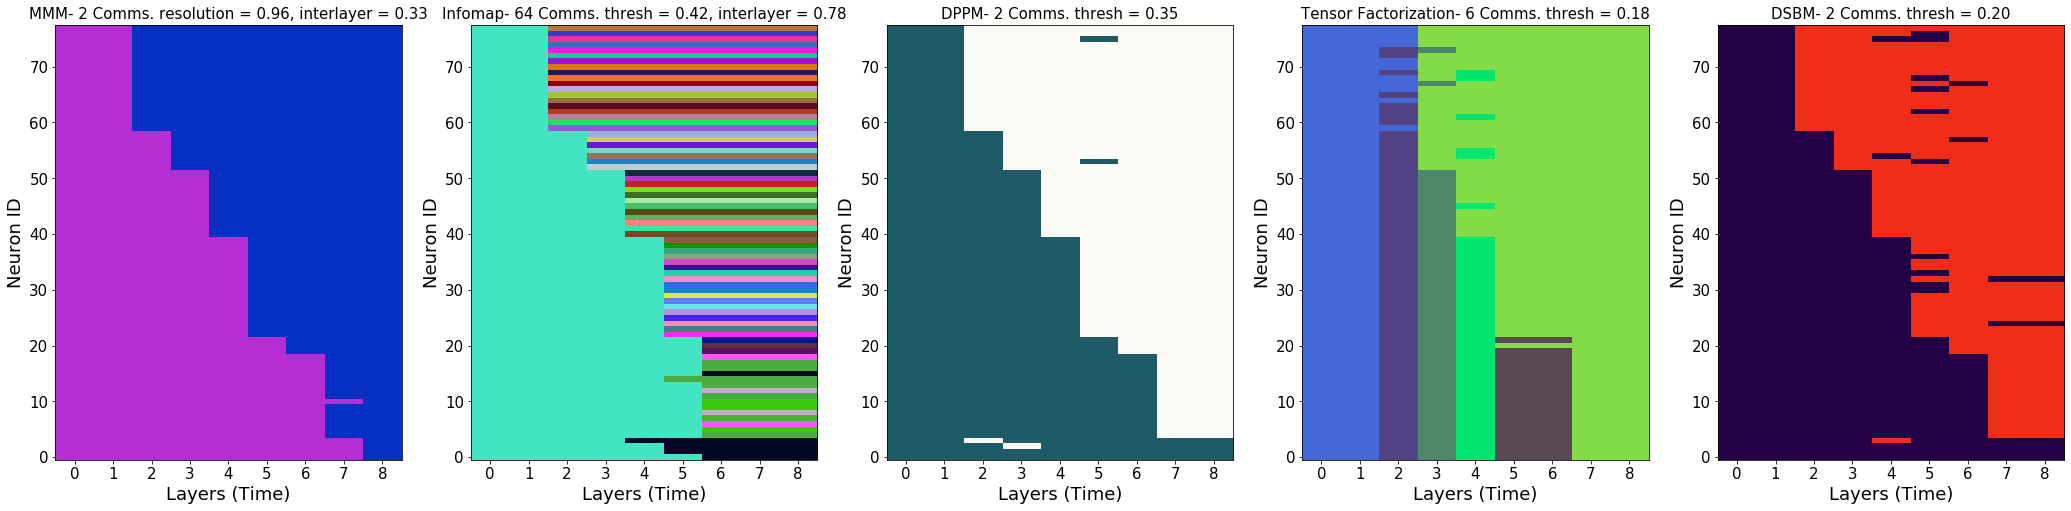

In [14]:
n = sum(C_ESCR_comm_size_mmm)
layers = 7

labels_mmm = C_ESCR_labels0_mmm[int(NMI1_mmm_0.argmax()/51)*len(resolutions)+NMI1_mmm_0.argmax()%51]
labels_infomap = C_ESCR_labels0_infomap[int(NMI1_infomap_0.argmax()/51)*len(thresholds_infomap)+NMI1_infomap_0.argmax()%51]
labels_dppm = labels0_k_2['%d'%(NMI1_dppm_0.argmax()%len(thresholds_dppm))]

labels_tensor = C_ESCR_labels0_tensor[np.unravel_index(NMI1_tensor_0.argmax(), 
                 NMI1_tensor_0.shape)[0]*len(thresholds_tensor) + np.unravel_index(NMI1_tensor_0.argmax(), NMI1_tensor_0.shape)[1]]

labels_dsbm = C_ESCR_labels0_dsbm[np.unravel_index(NMI1_dsbm_0.argmax(), 
                 NMI1_dsbm_0.shape)[0]*len(thresholds_dsbm) + np.unravel_index(NMI1_dsbm_0.argmax(), NMI1_dsbm_0.shape)[1]]

number_of_colors_mmm = int(max(labels_mmm)+1)
number_of_colors_infomap = int(max(labels_infomap)+1)
number_of_colors_dppm = int(max(labels_dppm)+1)
number_of_colors_tensor = int(max(labels_tensor)+1)
number_of_colors_dsbm = int(max(labels_dsbm)+1)

membership_mmm = [[] for i in range(number_of_colors_mmm)]
membership_infomap = [[] for i in range(number_of_colors_infomap)]
membership_dppm = [[] for i in range(number_of_colors_dppm)]
membership_tensor = [[] for i in range(number_of_colors_tensor)]
membership_dsbm = [[] for i in range(number_of_colors_dsbm)]

for i,m in enumerate(labels_mmm):
    time = floor(i/n)
    node_id = i%n
    membership_mmm[int(m)].append((node_id,time))
    
for i,m in enumerate(labels_infomap):
    time = floor(i/n)
    node_id = i%n
    membership_infomap[int(m)].append((node_id,time))
    
for i,m in enumerate(labels_dppm):
    time = floor(i/n)
    node_id = i%n
    membership_dppm[int(m)].append((node_id,time))
    
for i,m in enumerate(labels_tensor):
    time = floor(i/n)
    node_id = i%n
    membership_tensor[int(m)].append((node_id,time))

for i,m in enumerate(labels_dsbm):
    time = floor(i/n)
    node_id = i%n
    membership_dsbm[int(m)].append((node_id,time))

fig,ax = plt.subplots(1,5, figsize = (36,8))

comms_mmm = np.zeros((n,layers+2))
comms_infomap = np.zeros((n,layers+2))
comms_dppm = np.zeros((n,layers+2))
comms_tensor = np.zeros((n,layers+2))
comms_dsbm = np.zeros((n,layers+2))

color_mmm = ["#"+''.join([random.choice('0123456789ABCDEF') for j in range(6)]) for i in range(number_of_colors_mmm)]
color_infomap = ["#"+''.join([random.choice('0123456789ABCDEF') for j in range(6)]) for i in range(number_of_colors_infomap)]
color_dppm = ["#"+''.join([random.choice('0123456789ABCDEF') for j in range(6)]) for i in range(number_of_colors_dppm)]
color_tensor = ["#"+''.join([random.choice('0123456789ABCDEF') for j in range(6)]) for i in range(number_of_colors_tensor)]
color_dsbm = ["#"+''.join([random.choice('0123456789ABCDEF') for j in range(6)]) for i in range(number_of_colors_dsbm)]

for i, l in enumerate(membership_mmm):
    for j,k in enumerate(l):
        comms_mmm[k[0]][k[1]] = i
for i, l in enumerate(membership_infomap):
    for j,k in enumerate(l):
        comms_infomap[k[0]][k[1]] = i
for i, l in enumerate(membership_dppm):
    for j,k in enumerate(l):
        comms_dppm[k[0]][k[1]] = i
for i, l in enumerate(membership_tensor):
    for j,k in enumerate(l):
        comms_tensor[k[0]][k[1]] = i
for i, l in enumerate(membership_dsbm):
    for j,k in enumerate(l):
        comms_dsbm[k[0]][k[1]] = i

cmap_mmm = mpl.colors.ListedColormap(color_mmm)
cmap_infomap = mpl.colors.ListedColormap(color_infomap)
cmap_dppm = mpl.colors.ListedColormap(color_dppm)
cmap_tensor = mpl.colors.ListedColormap(color_tensor)
cmap_dsbm = mpl.colors.ListedColormap(color_dsbm)

ax[0].imshow(comms_mmm, interpolation = 'none', cmap = cmap_mmm, aspect = 'auto', origin = 'lower', extent = [-0.5,layers+2-0.5,-0.5,n-0.5])
ax[0].set_xticks([i for i in range(layers+2)])
ax[0].set_yticks([i*10 for i in range(int(n/10)+1)])
ax[0].tick_params(axis = 'both', labelsize = 15)
ax[0].set_xlabel('Layers (Time)', fontsize = 18)
ax[0].set_ylabel('Neuron ID', fontsize = 18)
ax[0].set_title('MMM- %d Comms. resolution = %.2f, interlayer = %.2f' %(len(color_mmm), 
                                                                        resolutions[np.unravel_index(NMI1_mmm_0.argmax(), 
                                                                                                     NMI1_mmm_0.shape)[1]], 
                                                                        interlayers[np.unravel_index(NMI1_mmm_0.argmax(),
                                                                                                     NMI1_mmm_0.shape)[0]]), 
                fontsize = 15)

ax[1].imshow(comms_infomap, interpolation = 'none', cmap = cmap_infomap, aspect = 'auto', origin = 'lower', extent = [-0.5,layers+2-0.5,-0.5,n-0.5])
ax[1].set_xticks([i for i in range(layers+2)])
ax[1].set_yticks([i*10 for i in range(int(n/10)+1)])
ax[1].tick_params(axis = 'both', labelsize = 15)
ax[1].set_xlabel('Layers (Time)', fontsize = 18)
ax[1].set_ylabel('Neuron ID', fontsize = 18)
ax[1].set_title('Infomap- %d Comms. thresh = %.2f, interlayer = %.2f' %(len(color_infomap), 
                                                                        thresholds_infomap[np.unravel_index(NMI1_infomap_0.argmax(), 
                                                                                                            NMI1_infomap_0.shape)[1]], 
                                                                        interlayers[np.unravel_index(NMI1_infomap_0.argmax(), 
                                                                                                     NMI1_infomap_0.shape)[0]]), 
                fontsize = 15)

ax[2].imshow(comms_dppm, interpolation = 'none', cmap = cmap_dppm, aspect = 'auto', origin = 'lower', extent = [-0.5,layers+2-0.5,-0.5,n-0.5])
ax[2].set_xticks([i for i in range(layers+2)])
ax[2].set_yticks([i*10 for i in range(int(n/10)+1)])
ax[2].tick_params(axis = 'both', labelsize = 15)
ax[2].set_xlabel('Layers (Time)', fontsize = 18)
ax[2].set_ylabel('Neuron ID', fontsize = 18)
ax[2].set_title('DPPM- %d Comms. thresh = %.2f' %(len(color_dppm), 
                                                  thresholds_dppm[np.unravel_index(NMI1_dppm_0.argmax(), 
                                                                                   NMI1_dppm_0.shape)[1]]), 
                fontsize = 15)

ax[3].imshow(comms_tensor, interpolation = 'none', cmap = cmap_tensor, aspect = 'auto', origin = 'lower', extent = [-0.5,layers+2-0.5,-0.5,n-0.5])
ax[3].set_xticks([i for i in range(layers+2)])
ax[3].set_yticks([i*10 for i in range(int(n/10)+1)])
ax[3].tick_params(axis = 'both', labelsize = 15)
ax[3].set_xlabel('Layers (Time)', fontsize = 18)
ax[3].set_ylabel('Neuron ID', fontsize = 18)
ax[3].set_title('Tensor Factorization- %d Comms. thresh = %.2f' %(len(color_tensor), 
                                                                  thresholds_tensor[np.unravel_index(NMI1_tensor_0.argmax(), 
                                                                                                     NMI1_tensor_0.shape)[1]]), 
                fontsize = 15)

ax[4].imshow(comms_dsbm, interpolation = 'none', cmap = cmap_dsbm, aspect = 'auto', origin = 'lower', extent = [-0.5,layers+2-0.5,-0.5,n-0.5])
ax[4].set_xticks([i for i in range(layers+2)])
ax[4].set_yticks([i*10 for i in range(int(n/10)+1)])
ax[4].tick_params(axis = 'both', labelsize = 15)
ax[4].set_xlabel('Layers (Time)', fontsize = 18)
ax[4].set_ylabel('Neuron ID', fontsize = 18)
ax[4].set_title('DSBM- %d Comms. thresh = %.2f' %(len(color_dsbm), 
                                                  thresholds_dsbm[np.unravel_index(NMI1_dsbm_0.argmax(), 
                                                                                   NMI1_dsbm_0.shape)[1]]), 
                fontsize = 15)

plt.savefig(path + 'example_max_partitions.pdf')